# Resoudre un TSP avec la Programmation Lineaire


Rappel: la programmation lineaire resoud des problemes d _optimisation sous contraintes_.

Un probleme se compose de

- variables: une variable est un element nomme qui peut prendre ses valeurs dans unintrevalle. Une variable peut aussi etre constrainte a prendre des valeurs _entieres_. Le solver lineaire va determiner
la valeur qui correspond a la meilleure valeur de l'objectif.
- des contraintes _lineaires_, c'est a dire a base de combinaisons lineaires de variables, de la forme $$\sum_{i} a_i X_i <= b_i$$ (ou >=, ou ==), mais jamais d operateur strict).
- un objectif, c est a dire une forme lineaire a minimiser ou maximiser (c est la meme chose, en changeant de signe).


## Plan du notebook

### Les outils
### Les donnees d entree
### Modeliser un TSP avec la programmation lineaire

 - les variables binaires
 - les contraintes de noeuds
 - la fonctuion de cout
    


## Les outils

Nous utilisons le solver lineaire CPLEX, dans sa version gratuite, limitee a 1000 variables, 1000 constraintes. Comme nous le verrons, cela suffit pour de petits TSP.
Pour piloter le solver lineaire et ecrire nos modeles en Python, nous utiliserons le module DOcplex (https://pypi.org/project/docplex/)

La documentation est a rechercher ici: http://ibmdecisionoptimization.github.io/docplex-doc/mp/refman.html

## Les donnees d'entree

Les donnees seront supposees fournies comme une liste de 3-tuples comportant unnom et deux coordonnees.

La mesure de distance est fournie comme une fonction prenant deux arguments de ce type.

On ne suppose pas que la distance soit symetrique, a priori le probleme est _asymetrique_; le temps passe en remontant au vent est plus long que si le vent est portant.


In [1]:
# Model est la classe qui permet de decrire les modeles.
from docplex.mp.model import Model

## Modeliser un TSP avec la programmation lineaire

### Une premiere modelisation

#### les variables binaires

Pour chaque couple (i,j) avec $i \neq j$ on definit une variable _binaire_ (deux valeurs possibles) $a_{i,j}$ qui vaut 1 si $c_j$ est le successeur de $c_i$ dans le trajet optimal, et 0 sinon.

#### Les contraintes

Pour tout noeud, on a exactement un arc sortant et exacement un arc entrant, soit:

$$\sum_{j} a{_{i,j}} == 1$$

$$\sum_{j} a{_{j, i}} == 1$$

On verifie que ces contraintes sont bien lineaires.

#### La fonction de cout a optimiser

On veut minimiser la distance soit $\sum a_{i,j} d(i,j)$, avec $d_{i,j}$ la distance entre les points i et j. (qui est une constante.)


Ecrivons un tel modele lineaire sur un petit exemple avec 8 points....

In [2]:
import math

g8 = [(0, 0, 'A'), (0, 10, 'B'), (10, 10, 'C'), (10, 0, 'D'),
          (60, 0, "E"), (70, 0, "F"), (70, 10, "G"), (60, 10, "H")]

# la fonction de distance.
# par convention , les points sont des triplets (nom, coord1, coord2)
# pour longitude/ latitude, on prend comme convention (latitude, longitude)
def euclide(c1, c2):
    x11, x12, _ = c1
    x21, x22, _ = c2
    d = (x11 - x21) ** 2 + (x22 - x12) ** 2
    return math.sqrt(d)

### Comment utiliser le module docplex pour poser le modele lineaire:

Indications:

1. creer un modele a partir de la classe `docplex.mp.model.Model` avec le nom 'tsp1'
    >. m = Model(name='tsp8')
2. creer un dicitionnaire de variables binaires (cad pouvant prendre des valeurs 0 ou 1, exclusivement). Les cles dece dctionnaire seront les arcs (pi, pj) avec pi, pj de spoints differents. 
3. ajouter les contraintes au modele en utilisant `Model.add_constraint`. Pour calculer la somme de variables, il faut imperativement utiliser la fonction `Model.sum` et pas le `sum` de Python. 
4. Definir l'objectif comme longueur totale du chemin, en utilisant `Model.minimize`

Note: a tout instant on peut utiliser la fonction `Model.print_information()` pour savoir combien d'objets contient le modele.

**Les fonctions utilisees**:

- **Model(name='tsp1')** ppour creer un objet modele, avec un nom,
- **m.print_information()** pour afficher les informations sur le modele
- **m.binary_var_dict(keys, name)** pour creer un dict de variables binaires avec les cles `keys`.
- **m.add_constraint()** pour ajouter une contrainte lineaire au probleme.
- **m.dotf()** pour calculer un produit scalaire _fonctionnel_
- **m.minimize()** pour minimser une expression lineaire.
- **m.solve()** pour resoudre le probleme lineaire
    Cette fonction retourne une solution qui donne la valeur des variables a l optimum.
    On peut passer un argument mot-cle "log_output=True" pour voir la trace pendant le solve.

In [3]:
import docplex
docplex.__version__


'2.13.184'


Pour creer le modele, nous partirons des arcs possibles soit les couples(pi, pj) avec i different de j.
Il y a exactement 7\*8 = 56 arcs

In [4]:
cities = g8

nb_cities  = len(cities)
arcs = [ (cities[i], cities[j]) for i in range(nb_cities) for j in range(nb_cities) if i != j]

# combien de paires: n^2 - n = n(n-1)
assert len(arcs) == nb_cities * (nb_cities-1)
arcs[:4]

[((0, 0, 'A'), (0, 10, 'B')),
 ((0, 0, 'A'), (10, 10, 'C')),
 ((0, 0, 'A'), (10, 0, 'D')),
 ((0, 0, 'A'), (60, 0, 'E'))]

## Creer un modele vide

Pour creer un modele on nlui passe son nom (une chaine de caracteres).

In [5]:
from docplex.mp.model import Model

tsp1 = Model(name='tsp1')
# a ce stade le modele est vide: ni variables ni contraintes
# son type est LP par defaut, c est a dire Linear Program
tsp1.print_information()

Model: tsp1
 - number of variables: 0
   - binary=0, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: LP


### Definir les variables binaires

Q1: combien de variables binaires?
Q2: a quoi est associee une variable binaire


Chaque variables est nommee par une chaine de caracteres. On va passer a la
fonction `Model.binary_var_dict` les cles, c'est a dire les objets qui nous serviront a retrouver les variables, 
et une fonction, qui prend une cle et retourne le nom de la variable (une chaine de caracteres).


In [6]:
# une fonction qui cree des noms: son argument est le tuple (p,q) qu il faut destructurer
# Le nom de la variable d arc entre (0,0, "Paris") et (1,1,, "London") sera  "Paris_to_London"
def nom_arc(pq):
    p, q = pq
    return "{0}_to_{1}".format(p[2], q[2])

In [7]:

# on utilise la fonction binary_var_dict,quiretourne un dictionnaire Python
# les cles sont les arcs (pi, pj).
arc_vars = tsp1.binary_var_dict(arcs, name=nom_arc)
# on verifie qu on a bien 56 = 8 * (8-1) variables binaires...

# noter que le type est devenu MILP: Mixed Integer Linear Program,
# car on a ajoute des variables binaires (type entier) au probleme.
tsp1.print_information()

Model: tsp1
 - number of variables: 56
   - binary=56, integer=0, continuous=0
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


### Ajouter les contraintes de noeuds

pour chaque noud (=ville) , on pose deux contraintes:

1. le nombre des arcs _entrants_ est exactement 1
2. le nombre des arcs _sortants_ est exactement 1.

Comme les variables sont binaires, cela signifie que dans les deux cas une variable et une seule est egale a 1, les autres valant 0.

On verra que ces contraintes seules ne sont pas suffisantes, et qu il faudra en ajouter d autres.

*Question*: si $N$ designe le nombre de points, combien a t on defini de contraintes de ce type? le verifier.

In [8]:
arcs

[((0, 0, 'A'), (0, 10, 'B')),
 ((0, 0, 'A'), (10, 10, 'C')),
 ((0, 0, 'A'), (10, 0, 'D')),
 ((0, 0, 'A'), (60, 0, 'E')),
 ((0, 0, 'A'), (70, 0, 'F')),
 ((0, 0, 'A'), (70, 10, 'G')),
 ((0, 0, 'A'), (60, 10, 'H')),
 ((0, 10, 'B'), (0, 0, 'A')),
 ((0, 10, 'B'), (10, 10, 'C')),
 ((0, 10, 'B'), (10, 0, 'D')),
 ((0, 10, 'B'), (60, 0, 'E')),
 ((0, 10, 'B'), (70, 0, 'F')),
 ((0, 10, 'B'), (70, 10, 'G')),
 ((0, 10, 'B'), (60, 10, 'H')),
 ((10, 10, 'C'), (0, 0, 'A')),
 ((10, 10, 'C'), (0, 10, 'B')),
 ((10, 10, 'C'), (10, 0, 'D')),
 ((10, 10, 'C'), (60, 0, 'E')),
 ((10, 10, 'C'), (70, 0, 'F')),
 ((10, 10, 'C'), (70, 10, 'G')),
 ((10, 10, 'C'), (60, 10, 'H')),
 ((10, 0, 'D'), (0, 0, 'A')),
 ((10, 0, 'D'), (0, 10, 'B')),
 ((10, 0, 'D'), (10, 10, 'C')),
 ((10, 0, 'D'), (60, 0, 'E')),
 ((10, 0, 'D'), (70, 0, 'F')),
 ((10, 0, 'D'), (70, 10, 'G')),
 ((10, 0, 'D'), (60, 10, 'H')),
 ((60, 0, 'E'), (0, 0, 'A')),
 ((60, 0, 'E'), (0, 10, 'B')),
 ((60, 0, 'E'), (10, 10, 'C')),
 ((60, 0, 'E'), (10, 0, 'D')),


In [9]:
c1 = cities[0]
e = sum([arc_vars[a] for a in arcs if a[0] == c1])
e

docplex.mp.LinearExpr(A_to_B+A_to_C+A_to_D+A_to_E+A_to_F+A_to_G+A_to_H)

In [10]:
for c in cities:
    # calculer la somme des arcs entrants (une expression)
    entrants = [arc_vars[a] for a in arcs if a[1] == c]
    # ajouter une contrainte expriamnt que cette somme vaut 1
    tsp1.add(tsp1.sum(entrants) == 1)
    # calculer la somme des arcs sortants (une expression)
    sortants = [arc_vars[a] for a in arcs if a[0] ==c]
    # ajouter une contrainte expriamnt que cette somme vaut 1
    tsp1.add_constraint(tsp1.sum(sortants) == 1)
    
# verifier le nombre de contraintes ajoutees: quel nombre est attendu??
tsp1.print_information()

Model: tsp1
 - number of variables: 56
   - binary=56, integer=0, continuous=0
 - number of constraints: 16
   - linear=16
 - parameters: defaults
 - objective: none
 - problem type is: MILP


## Definir l'objectif

Le but est de _minimiser_ la distance totale, on va donc utiliser la fonction `Model.minimize()`.
On doit lui passer la longeueur totale du chamin resultat. Pour chaque arc possible, on connait sa longueur, calculeee par la fonction de distance _d_.
La valeur de la distance est donc egale a $d(p_i,p_j)$ si $a_{i,j}$ vaut 1, 0 sinon.


La distance totale s obtient en sommant ces quantites.

On pourra utiliser la fonction `Model.dotf` (pour **f**unctional **dot** ou produit scalaire fonctionnel. Cettte fonction prend un argument:

- un dictionnaire de variables, a partir d une cle $k$ donne une variable $x_k$: $d[k] = x_k$
- une fonction $f$ qui prend une cle $k$ en argument et retourne un flottant nombre $a_k$. Dans  notre cas, les cles sont les arcs, et on veut retourner la distance de pi a pj.

La fonction retourne la somme des $a_k x_k$ pour toutes les cles du dictionnaire.

**Note**: on fera attention a la signature de la fonction euclide, qui prend deux points en argument. Par contre, le dicitonnaire a pour cles des _tuples_ python avec deux points..

In [11]:
# for each arc, count the distance, and compute the sum using Model.sum(), not Python sum()
tsp1.minimize(tsp1.dotf(arc_vars, lambda pq: euclide(pq[0], pq[1])))

## Resoudre le probleme lineaire.

On utilise la methode `Model.solve`, qui lance le solveur lineaire.

Cette methode retourne un objet solution , qui contient toutes les valeurs de variables, soit 0 ou 1 dans notre cas.

In [12]:
s1 = tsp1.solve(log_output=True)

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Found incumbent of value 80.000000 after 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIP has 16 rows, 56 columns, and 112 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.06 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 16 rows, 56 columns, and 112 nonzeros.
Reduced MIP has 56 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.10 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Clique table members: 16.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.04 ticks)

        Nodes                                         Cuts/
   Node  Left    

## Analyser la solution

La fonction `Model.solve` retourne une _solution_. Une solution Docplex est un objet qui contient la valeur optimale pour chaque variable x. La valeur optimale de x est donnee par l operateur `[]`, soit `sol[x]` pour une variable `x` retourne la valeur optimale de `x`.

In [13]:
# sol.display() premet de visualiser la solution:
s1.display()

solution for: tsp1
objective: 80.000
A_to_B = 1
B_to_A = 1
C_to_D = 1
D_to_C = 1
E_to_F = 1
F_to_E = 1
G_to_H = 1
H_to_G = 1


In [14]:
# une fonction auxilaire qui convertit la solution en arcs.

def sol2arcs(sol):
    return [a for a in arcs if sol[arc_vars[a]] >= 0.5]

## Visualiser la solution

Avec matplotlib

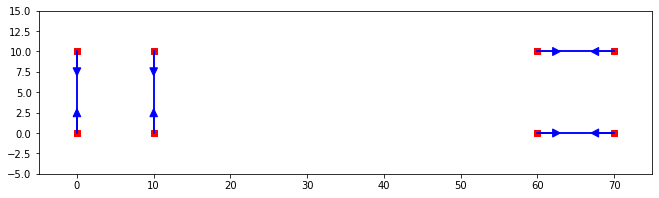

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


def afficher_graphe(arcs, marge=5, **kwargs):
    inverse_xy = kwargs.pop('inverse_xy', False)

    # afficher un graphe donne sous forme de couples (from, to)
    
    if inverse_xy:
        inv_arcs = []
        for a in arcs:
            start, end = a
            xa, ya, na = start
            xb, yb, nb = end
            inv_arcs.append( ((ya,xa, na), (yb, xb, nb)))
        return afficher_graphe(inv_arcs, marge, **kwargs)
    
    points = set(a[0] for a in arcs).union(set([a[1] for a in arcs]))

    def plot_arrow(s1, s2, f, color):
        ## afficher une fleche
        if inverse_xy:
            y0, x0, _ = s1
            y1, x1, _ = s2 
        else:
            x0, y0, _ = s1
            x1, y1, _ = s2
        line = plt.plot([x0, x1], [y0, y1], color=color)

        if f:
            dx = f * (x1 - x0)
            dy = f * (y1 - y0)
            a = plt.arrow(x0, y0, dx, dy, color=color, head_width=1, head_length=1)
    figsize =  kwargs.pop('figsize', (12,5))
    plt.figure(figsize=figsize)
    coords = [(p[0], p[1]) for p in points]
    xmin = min( c[0] for c in coords)
    xmax = max( c[0] for c in coords)
    ymin = min( c[1] for c in coords)
    ymax = max( c[1] for c in coords)
    plt.axis([xmin-marge, xmax+marge, ymin-marge, ymax+marge])

    plt.scatter([s[0] for s in points], [s[1] for s in points], color="red", marker="s")
    f = kwargs.pop('f', 0.2)
    for depart, arrivee in arcs:
        plot_arrow(depart, arrivee, f, color='blue')

    plt.show()
    
def afficher_solution(s, marge=5, **kwargs):
    afficher_graphe(sol2arcs(s), marge=marge, **kwargs)
    
def afficher_chemin(chemin, marge=5, **kwargs):
    n = len(chemin)
    arcs = [(chemin[i], chemin[i+1]) for i in range(n-1)]
    # close the loop
    arcs.append( (chemin[-1], chemin[0]) )
    afficher_graphe(arcs, marge=marge, **kwargs)
             
    
afficher_solution(s1, figsize=(11,3))

Le graphe ci dessus n est pas _hamiltonien_ car il contient des cycles, par exemple A-> B ->A. Ce n est pas surprenant car rien dans notre modele ne force la solution a representer un graphe hamiltonien complet.


## Reparation

Dans un premier temps, nous allons proceder par reparation iterative de la solution. 

L algorithme est:

1. chercher un sous-cyle dans la solution, c'est a dire un cycle de longueur < N.
    s il n y en a pas, on a fini, la solution contient bien un graphe hamiltonien.
    
2. sinon, on va ajouter une nouvelle contrainte qui rend ce cycle impossible au modele

3. puis on relance la resolution du modele, qui donne une nouvelle solution, puis on recommence a chercher un nouveau cycle.

Pour information, le solveur lineaire ne repart pas du debut, mais se sert de la solution precedente (qui n est plus valable a cause de notre nouvelle contrainte), mais il va quand meme essayer de la reparer.


## recherche de cycles

On part d une solution produite par le modele et on cherche un cycle, on retournera le plus petit (en taille).
Si le plus petit cycle est de longeuru N, on a fini!
Sinon, on va devoir reparer le modele en construisant une nouvealle contrainte qui rendra ce cycle impossible.

Les etapes:
 - calculer un dict des successeurs, c est a dire pour chaque point son successeur direct (il y en a un seul)
 - ensuite, on part d'un point et on visite ses successeurs, en les memorisant dans une liste (et aussi dans les points visites),
 jusqu'a ce qu'on revienne au point de depart. On regarde le cycle ainsi construit: s il contient tous les points (comment savoir?) on le retourne, sinon on continue avec un autre point et on retournera le plus petit cycle trouve.
    

In [16]:
def cherche_plus_petit_cycle(all_cities, arc_vars, solution):
    # les arcs
    arcs = list(arc_vars.keys())
    # convertir la solution en un dict arcs-> 1, 0
    liens = solution.get_value_dict(arc_vars)
    # un dict des successeurs: pi -> pj
    succs = {c1: c2 for (c1, c2) in arcs if liens.get((c1,c2), 0) >= 0.5}
    nb_cities = len(all_cities)
    assert nb_cities == len(succs)
    
    # ensemble des points visites
    visited = set()
    plus_petit_cycle = all_cities
    for c in all_cities:
        # si on est deja passe par c on passe au suivant
        if c in visited:
            continue
            
        # on calcule le chemin passant par c
        cur_chemin = []
        cur_node = c
        start_node = c
        # on s arrete si on retrouve le depart sauf si on est au depart.
        while cur_node != start_node or not cur_chemin:
            # ajoute aux visites
            visited.add(cur_node)
            #on ajoute au chemin courant
            cur_chemin.append(cur_node)
            # on passe au suivant
            next = succs[cur_node]
            cur_node = next
            
        # on a un chemin, on teste sa longueur
        if len(cur_chemin) < len(plus_petit_cycle):
            # c est un cycle, on le memorise pour tester le plus petit
            plus_petit_cycle = cur_chemin
        else:
            return cur_chemin
        
    # on retourne le plus court...
    return plus_petit_cycle

In [17]:
# on teste sur le graphe courant, on doit ttrouver un cycle de 2 points...
ch = cherche_plus_petit_cycle(g8, arc_vars, s1)
ch

[(10, 10, 'C'), (10, 0, 'D')]

# comment supprimer le cycle

Une fois le cycle _C_ identifie, on procedera de la facon suivante:

Un cycle _C_ definit en ensemble de sommets  _S1_, par hypothese, son complementaire _S2_ est non vide. 
On exprime alors que la solution optimale doit contenir au moins un arc qui part d un point de _S1_ vers un point de _S2_.

Note: il ne serait pas praticable d ajouter _a priori_ ces contraintes pour tous les sous-ensemble de points,
l ensemble des parties de _S_ etant  trop gros.

In [18]:
def coupe_cycle(cities, cycle, arc_vars, m):
    # two region cut: 
    # force at least one arc from subtour to the
    # complementary of the subtour. in fact there must be two arcs..
    # 1. calculer le complementaire 
    substour_set = set(cycle)
    subtour_comp = set(cprime for cprime in cities if cprime not in substour_set)
    # verification....
    assert len(substour_set) + len(subtour_comp) == len(cities)
    # ne rien faire si jamais le complementaire est vide sinon 
    # posterait une contrainte impossible du type 0 >= 1 ce qui bloquerait le modele....
    if len(subtour_comp) > 0:
 
        # calculer l esemble des arcs possibles de C1 vers C2
        break_edges = [(c1, c2) for c1 in substour_set for c2 in subtour_comp]
        # ajouter la contrainte que cette somme vaut au moins 1 (elle peut valoir plus...)
        m.add(m.sum_vars(arc_vars[bke] for bke in break_edges) >= 1)

Tester le coupe-cycles sur la solution courante,
verifier que l on a bien ajoute une contrainte, et relancer la resolution.

In [19]:
coupe_cycle(g8, ch, arc_vars, tsp1)
tsp1.print_information()

Model: tsp1
 - number of variables: 56
   - binary=56, integer=0, continuous=0
 - number of constraints: 17
   - linear=17
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [20]:
s2 = tsp1.solve()
s2.display()

solution for: tsp1
objective: 80.000
A_to_B = 1
B_to_C = 1
C_to_D = 1
D_to_A = 1
E_to_F = 1
F_to_G = 1
G_to_H = 1
H_to_E = 1


A nouveau on cherche le plus petit cycle, on doit trouver un cycle different.

etape 2: plus petit cyle longueur: 4


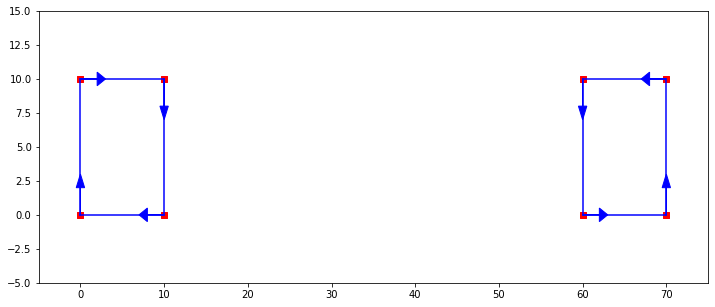

In [21]:
ch2 = cherche_plus_petit_cycle(g8, arc_vars, s2)
print("etape 2: plus petit cyle longueur: {0}".format(len(ch2)))
afficher_solution(s2)

etape 3: plus petit cyle longueur: 4


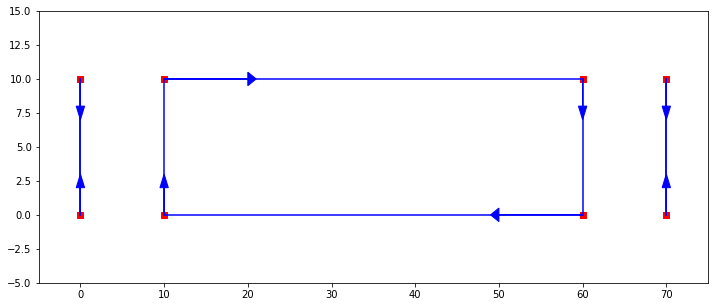

etape 4: plus petit cyle longueur: 2


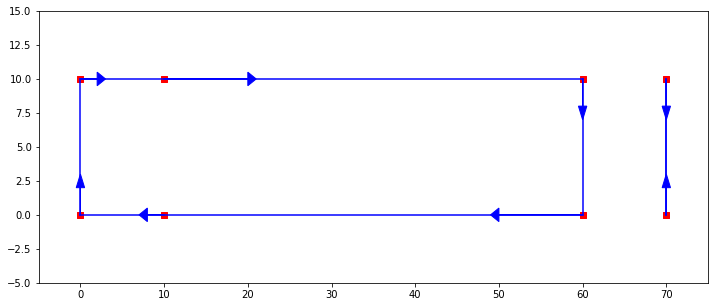

etape 5 plus petit cyle longueur: 6


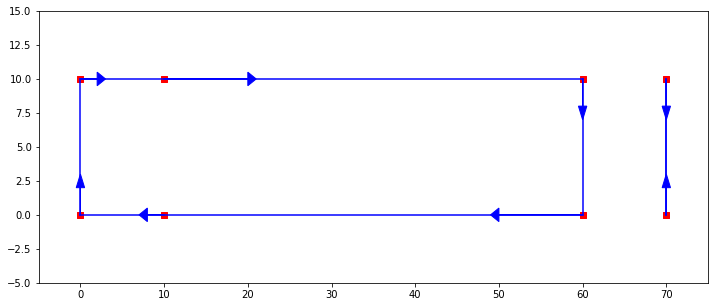

In [22]:
coupe_cycle(g8, ch2, arc_vars, tsp1)
s3 = tsp1.solve()
ch3 = cherche_plus_petit_cycle(g8, arc_vars, s3)
print("etape 3: plus petit cyle longueur: {0}".format(len(ch3)))
afficher_solution(s3)

coupe_cycle(g8, ch3, arc_vars, tsp1)
s4 = tsp1.solve()
ch4 = cherche_plus_petit_cycle(g8, arc_vars, s4)
print("etape 4: plus petit cyle longueur: {0}".format(len(ch4)))
afficher_solution(s4)

coupe_cycle(g8, ch4, arc_vars, tsp1)
s5 = tsp1.solve()
ch5 = cherche_plus_petit_cycle(g8, arc_vars, s5)
print("etape 5 plus petit cyle longueur: {0}".format(len(ch5)))
afficher_solution(s4)



## Algorithme iteratif

Ecrire un algorithme iteratif en suivant les etapes precedentes:

1. la fonction prendra en argument

1. une liste de points, comme des triplets (nom, x1, x2)
2. une fonction de distance : PxP -> float
3. un nombre maximum d iterations, disons 100.
3. un flag verbose pour ecrire des messages

L algorithme retournera un tuple des deux elements:
le premier est la distance totale du chemin le plus court,
le secondune liste de points ordonnes qui represente le chemin

Les etapes de l algorithme sont:

- creer un modele de TSP avec variables binaires et contraintes de noeuds
- le resoudre une premiere fois.
- tant que le modele contient au moins un cycle de longueur < N: faire
   - couper le cycle a l aide de la methode deja vue
   - lancer a nouveau la resolution
   - retourner a la recherche de cycle:
       soit on trouve un cycle de longueur < N et on continue
       soit le cycle contient tous les points et on a fini, on a trouve le cycle optimal.


Question: les etapes precedentes on montre des cycles de longeur 2.
Comment pourrait on eliminer  tels cycles de maniere simple,
et ceci des la construction du modele?

Quel est l impact de cette modification sur le nombre de contraintes?


In [23]:
def tsp_lineaire(cities, distance_fn, verbose=True, iter_max=100):
    
    def cycle_2_string(cyc):
        return " -> ".join(c[2] for c in cyc) + " -> ..."
    
    tspm = Model(name="tsp")
    nb_cities  = len(cities)
    arcs = [ (cities[i], cities[j]) for i in range(nb_cities) for j in range(nb_cities) if i != j]
    arc_vars = tspm.binary_var_dict(arcs, name=nom_arc)
    
    # les d arcs entrant et sortant
    for c in cities:
        entrants = [arc_vars[c1, c] for c1 in cities if c1 != c]
        tspm.add(tspm.sum(entrants) == 1)
        sortants = [arc_vars[c, c2] for c2 in cities if c2 != c]
        tspm.add_constraint(tspm.sum(sortants) == 1)
    
    # une contrainte pour supprimer les 2-cycles
    for (pi, pj) in arcs:
        if pi < pj:
            tspm.add( arc_vars[pi, pj] + arc_vars[pj,pi] <= 1)
    
    # objectif
    # for each arc, count the distance, and compute the sum using Model.sum(), not Python sum()
    # attention: transformer la distance (c1, c2) -> d en distance( 2-tuple) -> d
    
    tspm.minimize(tspm.dotf(arc_vars, lambda pq: distance_fn(pq[0], pq[1])))

    tspm.print_information()

    n_iter = 0
    while n_iter <= iter_max:
        n_iter += 1
        if verbose:
            print("-- tsp: iteration #{0}".format(n_iter))
        s = tspm.solve()
        assert s
        ch = cherche_plus_petit_cycle(cities, arc_vars, s)
        print("trouve cycle longueur: {0}: {1}".format(len(ch), cycle_2_string(ch)))
        if len(ch) == nb_cities:
            # on a fini
            lmin = s.objective_value
            return lmin, ch
        else:
            # couper le cycle
            coupe_cycle(cities, ch, arc_vars, tspm)
    # 
    print("nombre maximum d iterations atteint...")
    return s.objective_value, ch
        


## Les ports de la Mer Noire.

On va tester le code lineaire sur les ports de la mer noire.

Dans le probleme de la Mer Noire, la distance est donnee par une matrice NxN, non symetrique: la distance de A a B peut etre differente de la distance de B a A.

On va appliquer l algorithme precedent en convertissant la matrice en fonction.

Dans ce cas, les coordonnees des points ne servent pas au calcul de distance,
uniquement a l affichage des resultats..

### les donnnees

In [24]:
# la distance comme tuples: v1, v2, d
distance_mer_noire = [('prague', 'varna', 1279),
 ('prague', 'burgas', 1304),
 ('varna', 'prague', 1279),
 ('varna', 'constanza', 160),
 ('varna', 'izmail', 438),
 ('varna', 'reni', 372),
 ('varna', 'galata', 349),
 ('varna', 'braila', 332),
 ('burgas', 'prague', 1304),
 ('burgas', 'constanza', 290),
 ('burgas', 'izmail', 502),
 ('burgas', 'reni', 436),
 ('burgas', 'galata', 414),
 ('burgas', 'braila', 393),
 ('constanza', 'varna', 158),
 ('constanza', 'burgas', 288),
 ('constanza', 'izmail', 283),
 ('constanza', 'reni', 217),
 ('constanza', 'galata', 194),
 ('constanza', 'braila', 178),
 ('izmail', 'varna', 435),
 ('izmail', 'burgas', 503),
 ('izmail', 'constanza', 283),
 ('izmail', 'reni', 66),
 ('izmail', 'galata', 89),
 ('izmail', 'braila', 111),
 ('reni', 'varna', 369),
 ('reni', 'burgas', 437),
 ('reni', 'constanza', 217),
 ('reni', 'izmail', 66),
 ('reni', 'galata', 23.3),
 ('reni', 'braila', 44.4),
 ('galata', 'varna', 346),
 ('galata', 'burgas', 414),
 ('galata', 'constanza', 194),
 ('galata', 'izmail', 89),
 ('galata', 'reni', 23.3),
 ('galata', 'braila', 21.5),
 ('braila', 'varna', 330),
 ('braila', 'burgas', 392),
 ('braila', 'constanza', 177),
 ('braila', 'izmail', 110),
 ('braila', 'reni', 44.6),
 ('braila', 'galata', 21.7)]

# villes comme l ensemble des noms:
noms_villes_mer_noire = set()
for v1, v2, _ in distance_mer_noire:
    noms_villes_mer_noire.add(v1)
    noms_villes_mer_noire.add(v2)
    
print(" il y a {0} villes: {1}".format(len(noms_villes_mer_noire), noms_villes_mer_noire))

# les villes avec latitude longitude
coords_mer_noire = {"varna": (43.212, 27.917),
                    "constanza": (44.166502, 28.612863),
                    "izmail": (45.351676, 28.833354),
                    "braila": (45.270865, 27.951651),
                    "burgas": (42.505048, 27.462281),
                    "reni": (45.456295, 28.284047),
                    "prague": (50.077612, 14.430638 ),
                    "galata": (41.020782, 28.973179)}
villes_mer_noire = [(vx1, vx2, vn) for vn, (vx1, vx2) in coords_mer_noire.items()]
nom_2_ville = {v[2]: v for v in villes_mer_noire}


matrice_mer_noire = { (nom_2_ville[n1], nom_2_ville[n2]): d for (n1, n2, d) in distance_mer_noire}
                
# la distance comme fonction
# attentionon capture la matrice dans une cloture!
def distance_mer_noire(v1, v2):
    # si (v1,v2) n est pas dans la matrice, on retourne une valeur enorme....
    return matrice_mer_noire.get((v1, v2), 1e+20)


 il y a 8 villes: {'reni', 'galata', 'varna', 'braila', 'prague', 'burgas', 'izmail', 'constanza'}


In [25]:
lmn, cmn = tsp_lineaire(villes_mer_noire, distance_fn=distance_mer_noire, verbose=True)
print("** distance minimum mer noire: {0}".format(lmn))
print("** le chemin optimal: {0}".format(" -> ".join(v[2] for v in cmn)))


# distance minimum mer noire: 3527.3
assert abs(lmn - 3527.3) <= 0.1

Model: tsp
 - number of variables: 56
   - binary=56, integer=0, continuous=0
 - number of constraints: 44
   - linear=44
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
-- tsp: iteration #1
trouve cycle longueur: 4: izmail -> reni -> galata -> braila -> ...
-- tsp: iteration #2
trouve cycle longueur: 3: izmail -> galata -> reni -> ...
-- tsp: iteration #3
trouve cycle longueur: 8: varna -> prague -> burgas -> braila -> izmail -> reni -> galata -> constanza -> ...
** distance minimum mer noire: 3527.3
** le chemin optimal: varna -> prague -> burgas -> braila -> izmail -> reni -> galata -> constanza


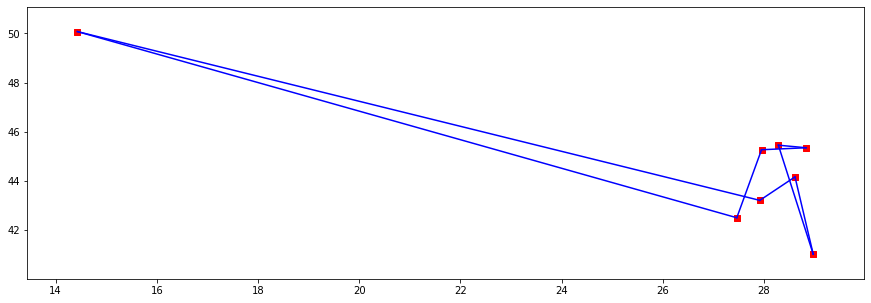

In [26]:
afficher_chemin(cmn, marge=1, inverse_xy=True, f=0, figsize=(15,5))

In [27]:
vmn7 = villes_mer_noire[:6]
vmn7

[(43.212, 27.917, 'varna'),
 (44.166502, 28.612863, 'constanza'),
 (45.351676, 28.833354, 'izmail'),
 (45.270865, 27.951651, 'braila'),
 (42.505048, 27.462281, 'burgas'),
 (45.456295, 28.284047, 'reni')]

In [28]:
lmn7, cmn7 = tsp_lineaire(vmn7, distance_fn=distance_mer_noire, verbose=True)
print("** distance minimum mer noire: {0}".format(lmn7))
print("** le chemin optimal: {0}".format(" -> ".join(v[2] for v in cmn7)))

Model: tsp
 - number of variables: 30
   - binary=30, integer=0, continuous=0
 - number of constraints: 27
   - linear=27
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
-- tsp: iteration #1
trouve cycle longueur: 6: varna -> constanza -> burgas -> braila -> izmail -> reni -> ...
** distance minimum mer noire: 1386.0
** le chemin optimal: varna -> constanza -> burgas -> braila -> izmail -> reni


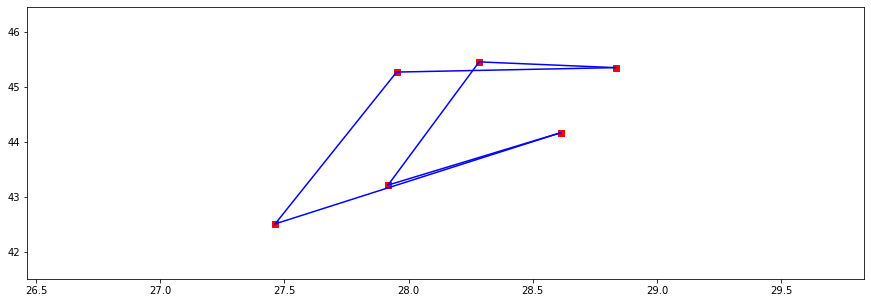

In [29]:
afficher_chemin(cmn7, marge=1, inverse_xy=True, f=0, figsize=(15,5))